In [349]:
import pandas as pd
pd.options.display.max_columns = 100
import numpy as np
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import lightgbm as lgb
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error

train_df = pd.read_csv('../input/train.csv')
test_df = pd.read_csv('../input/test.csv')
sample_submit = pd.read_csv('../input/sample_submit.csv',header=None, names=['id', 'y'])
print('train :', len(train_df))
print('test: ', len(test_df))
print('sample_submit :', len(sample_submit))

train : 55583
test:  18528
sample_submit : 18528


In [416]:
train = train_df.copy()


# preprocess

In [421]:
train = train_df.copy()
def processing_amenities(x):
    x = x.replace('{','')
    x = x.replace('}','')
    x = x.replace('"','')
    x = x.split(',')
    return x

train['amenities'] = train['amenities'].apply(processing_amenities)

def make_col(x, df):
    for i in x:
        if i not in df.columns:
            df[i] = 0
            # tmp = pd.Series(0, name=str(i))
            # pd.concat([df, tmp], axis=1)
train['amenities'].apply(make_col, df=train)
ß
# def make_onehot(x, df):
#     for i in x:
#         df[i] += 1
# train['amenities'].apply(make_onehot, df=train)  

/Users/shugo/Desktop/Competitions/SIGNATE/AIQuest2021/venv_AIQuest2021/lib/python3.7/site-packages/ipykernel_launcher.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider using pd.concat instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  


0        None
1        None
2        None
3        None
4        None
         ... 
55578    None
55579    None
55580    None
55581    None
55582    None
Name: amenities, Length: 55583, dtype: object

In [351]:
train = train_df.copy()
test = test_df.copy()
target = train.pop('y')
all_df = pd.concat([train, test], axis=0)
all_df = all_df.drop(['id','amenities', 'description'], axis=1)

# categorical columns
cat_col = ['bed_type', 'cancellation_policy', 'city',
            'cleaning_fee', 'host_has_profile_pic',
            'host_identity_verified', 'instant_bookable',
            'name', 'neighbourhood', 'property_type', 'room_type',
            'thumbnail_url']
all_df[cat_col] = all_df[cat_col].fillna('nan')
le = LabelEncoder()
for col in cat_col:
    all_df[col] = le.fit_transform(all_df[col])

def convert_date(df_, col):
    df = df_.copy()
    df[col] = pd.to_datetime(df[col])
    df[f'{col}_year'] = df[col].map(lambda x: x.year)
    df[f'{col}_month'] = df[col].map(lambda x: x.month)
    df[f'{col}_day'] = df[col].map(lambda x: x.day)
    df = df.drop(col, axis=1)
    return df
all_df = convert_date(all_df, 'first_review')
all_df = convert_date(all_df, 'host_since')
all_df = convert_date(all_df, 'last_review')


def processing_address(x):
    if type(x)!=float:
        x = x.strip('-')
    return x
all_df['zipcode'].apply(processing_address)
le = LabelEncoder()
all_df['zipcode'] = le.fit_transform(all_df['zipcode'])

def processing_rate(x):
    if x==object:
        x.strip('%')
    return x
all_df['host_response_rate'] = all_df['host_response_rate'].map(processing_rate)
le = LabelEncoder()
all_df['host_response_rate'] = le.fit_transform(all_df['host_response_rate'])

# others
le = LabelEncoder()
for col in all_df.columns:
    all_df[col] = le.fit_transform(all_df[col])


train = all_df[:55583]
test = all_df[55583:]
print('train :', len(train))
print('test :', len(test))

train : 55583
test : 18528


# train

In [352]:
n_splits = 5
kf = KFold(n_splits=n_splits, shuffle=True, random_state=71)
X = train
y = target
models = []
scores = []
preds = np.zeros((len(test),5))
for i, (train_index, valid_index) in enumerate(kf.split(X, y)):

    X_train = X.iloc[train_index]
    y_train = y.iloc[train_index]
    X_valid = X.iloc[valid_index]
    y_valid = y.iloc[valid_index]

    lgb_train = lgb.Dataset(X_train, y_train)
    lgb_valid = lgb.Dataset(X_valid, y_valid)

    params ={'objective':'regression',
            'seed':71,
            'verbose':-1,
            'metrics':'rmse'}
    model = lgb.train(params, lgb_train, verbose_eval=False, early_stopping_rounds=100,
                        valid_names=['train','test'], valid_sets=[lgb_train, lgb_valid])
    valid_pred = model.predict(X_valid)
    score = mean_squared_error(y_valid, valid_pred, squared=False)

    test_pred = model.predict(test)

    models.append(model)
    scores.append(score)
    preds[:,i] = test_pred
    print(f'Fold{i}', score)

print('cv:', np.mean(scores))

Fold0 106.24183635372124
Fold1 104.8019817054094
Fold2 105.84002304604783
Fold3 106.9875681942796
Fold4 113.67296730652673
rmse : 107.50887532119695


In [353]:
def visualize_importance():
    feature_importance_df = pd.DataFrame()

    for i,model in enumerate(models):
        _df = pd.DataFrame()
        _df['feature_importance'] = model.feature_importance(importance_type='gain')
        _df['column'] = X.columns
        _df['fold'] = i+1
        feature_importance_df = pd.concat([feature_importance_df,_df],axis=0,ignore_index=True)
    
    order = feature_importance_df.groupby('column').sum()[['feature_importance']].sort_values('feature_importance',ascending=False).index[:50]

    fig, ax = plt.subplots(1,1,figsize=(max(6, len(order) * .4), 6))
    sns.boxenplot(data=feature_importance_df, x='column', y='feature_importance', order=order, ax=ax, palette='viridis')
    ax.tick_params(axis='x', rotation=90)
    ax.grid()
    fig.tight_layout()
    return fig,ax

(<Figure size 921.6x432 with 1 Axes>,
 <AxesSubplot:xlabel='column', ylabel='feature_importance'>)

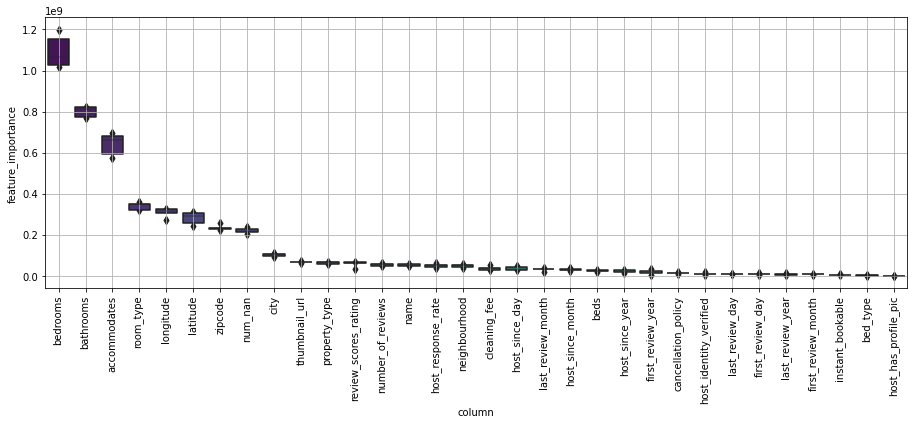

In [354]:
visualize_importance()

# submission

In [358]:
y_preds = []
for i in range(len(preds)):
    y_pred = np.mean(preds[i])
    y_preds.append(y_pred)
y_preds = pd.Series(y_preds)
sample_submit['y'] = y_preds
sample_submit.to_csv('../output/sub_nb000.csv', index=False, header=False)